<body>
    <h1 style="text-align: center;">Prédiction conforme</h1>
    <p>Ce Notebook implémente une méthode de prédiction conforme basée sur le papier :
    <a href="https://arxiv.org/pdf/2107.07511">A Gentle Introduction to Conformal Prediction and Distribution-Free Uncertainty Quantification</a>
    et le <a href="https://github.com/aangelopoulos/conformal-prediction/blob/main/notebooks/tumor-segmentation.ipynb">Notebook</a> sur la segmentation de tumeur sur le <a href="https://github.com/aangelopoulos/conformal-prediction">Github</a> associé.</p>
    <p>Voir aussi leur <a href="https://www.youtube.com/playlist?list=PLBa0oe-LYIHa68NOJbMxDTMMjT8Is4WkI">playlist youtube explicative</a> du papier.</p>
</body>

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from scipy.optimize import brentq
from skimage.transform import rescale, resize
#pip install -U --no-cache-dir gdown --pre

<p>On execute le BiomedParse pour récupérer les masques et sigmoids.</p>

## BiomedParse Setup

In [2]:
import G_inferenceCall as call
import pandas as pd

model = call.getModel()

[SRV-ML03:1611021] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.SRV-ML03.476685808/jf.0/2550202368/shared_mem_cuda_pool.SRV-ML03 could be created.
[SRV-ML03:1611021] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 
/home/gurrisi@clb.loc/anaconda3/envs/biomedparse/lib/python3.9/site-packages/kornia/feature/lightglue.py:30: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
/home/gurrisi@clb.loc/anaconda3/envs/biomedparse/lib/python3.9/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


Deformable Transformer Encoder is not available.
➡️  Type de tokenizer : clip
➡️  Chemin/tokenizer utilisé : ./local-tokenizer/clip-vit-base-patch32
➡️  Contenu complet config_encoder : {'ARCH': 'vlpencoder', 'NAME': 'transformer', 'TOKENIZER': 'clip', 'PRETRAINED_TOKENIZER': './local-tokenizer/clip-vit-base-patch32', 'CONTEXT_LENGTH': 77, 'WIDTH': 512, 'HEADS': 8, 'LAYERS': 12, 'AUTOGRESSIVE': True}
✅ Tokenizer FINAL utilisé: ./local-tokenizer/clip-vit-base-patch32


/home/gurrisi@clb.loc/anaconda3/envs/biomedparse/lib/python3.9/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/home/gurrisi@clb.loc/anaconda3/envs/biomedparse/lib/python3.9/site-packages/transformers/modeling_utils.py:484: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explici

In [3]:
predicted_masks, ground_truth_masks = call.getMasks(model)

data = pd.DataFrame({
    "sgmd": predicted_masks,
    "targets": ground_truth_masks
})

data


,sgmd,targets
0,"[[1.0065696e-11, 1.1453867e-13, 3.066237e-20, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,"[[1.035636e-10, 1.881808e-12, 3.2649729e-18, 1...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,"[[2.231754e-07, 3.4040816e-08, 2.1684077e-10, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,"[[1.3782556e-10, 7.1867755e-12, 8.1483595e-16,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,"[[3.1607158e-08, 2.9869722e-09, 3.3417884e-12,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...
1256,"[[5.9145414e-12, 1.6454242e-13, 1.5577216e-18,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1257,"[[7.836036e-11, 1.3548932e-12, 1.9283652e-18, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1258,"[[7.519442e-08, 8.597006e-09, 1.9510423e-11, 6...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1259,"[[8.690626e-11, 3.6397443e-12, 1.7429737e-16, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [59]:
alpha = 0.1

sgmd = data['sgmd'] # sigmoid scores
gt_masks = data['targets']

def false_negative_rate(pred_masks, true_masks):
    tp = (pred_masks * true_masks).sum(axis=1).sum(axis=1)
    total_positive = true_masks.sum(axis=1).sum(axis=1)
    
    # Éviter la division par zéro
    valid = total_positive > 0
    if not np.any(valid):
        return np.nan  # Aucun masque valide

    recall = tp[valid] / total_positive[valid]
    return 1 - recall.mean()


In [60]:
# Convertir les colonnes en tableaux NumPy
sgmd_array = np.array(sgmd.tolist())
gt_masks_array = np.array(gt_masks.tolist())

# Créer le masque booléen
n = 800
idx = np.array([1] * n + [0] * (sgmd_array.shape[0] - n)) > 0
np.random.shuffle(idx)

# Split
cal_sgmd, val_sgmd = sgmd_array[idx], sgmd_array[~idx]
cal_gt_masks, val_gt_masks = gt_masks_array[idx], gt_masks_array[~idx]


In [61]:
# Run the conformal risk control procedure
def lamhat_threshold(lam): return false_negative_rate(cal_sgmd>=lam, cal_gt_masks) - ((n+1)/n*alpha - 1/n)
lamhat = brentq(lamhat_threshold, 0, 1)
# lamhat = 1 - lamhat
# lamhat = 0.3
predicted_masks = val_sgmd >= lamhat

In [62]:
# Calculate empirical FNR
print(f"The empirical FNR is: {false_negative_rate(predicted_masks, val_gt_masks)} and the threshold value is: {lamhat}")

The empirical FNR is: 0.13855829118794116 and the threshold value is: 1.5544209489839977e-12


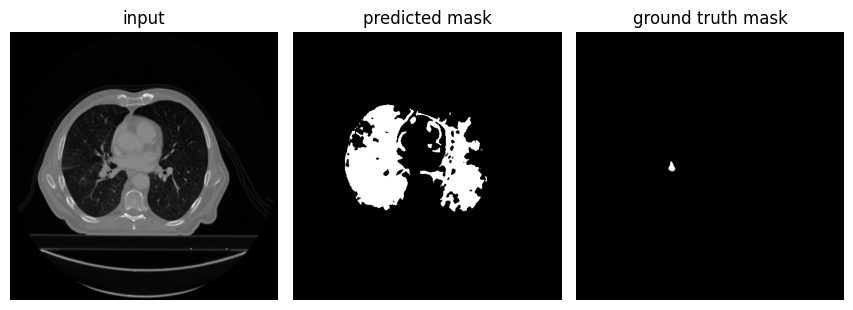

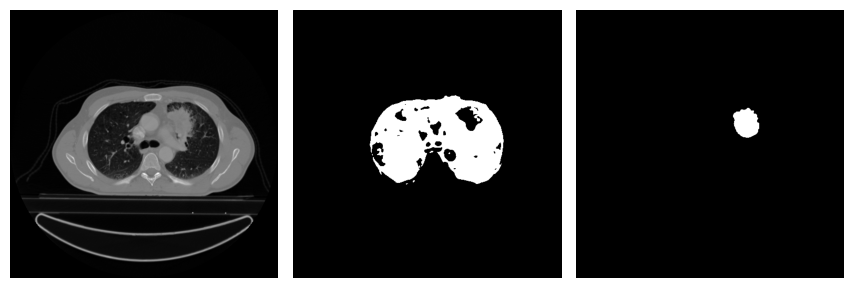

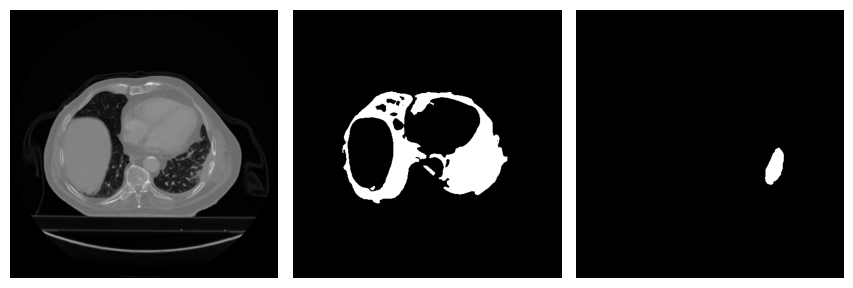

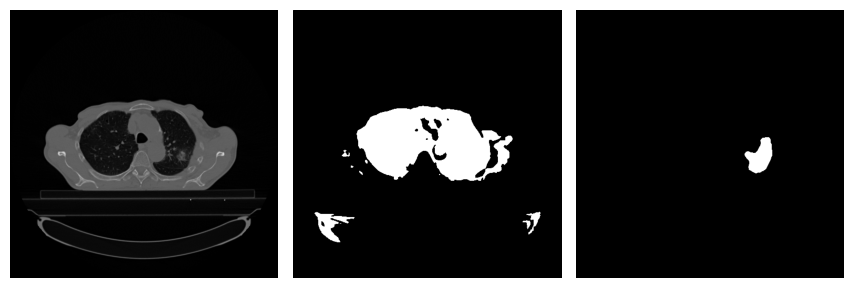

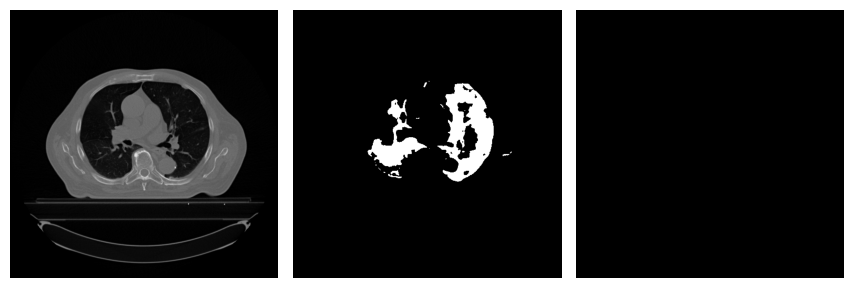

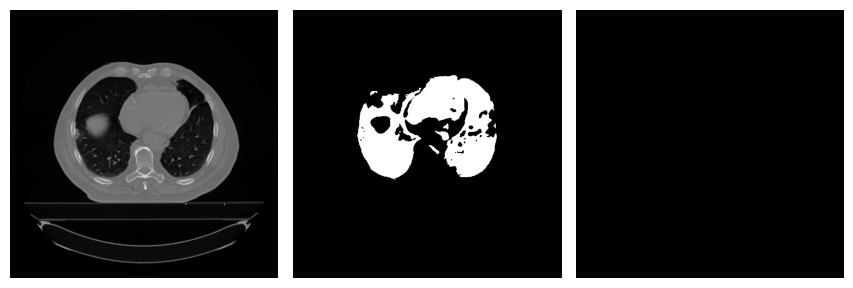

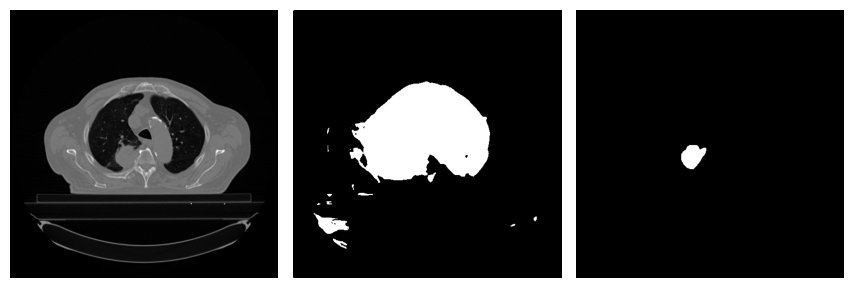

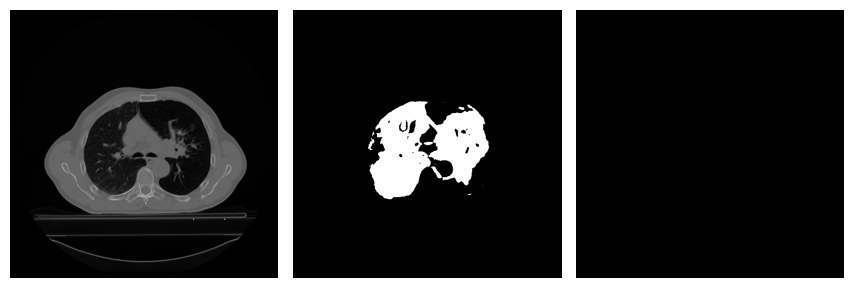

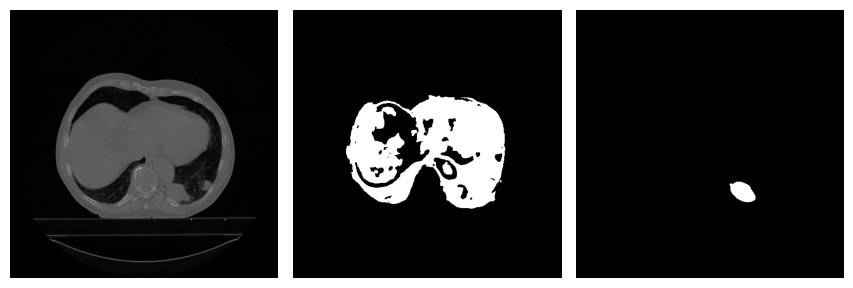

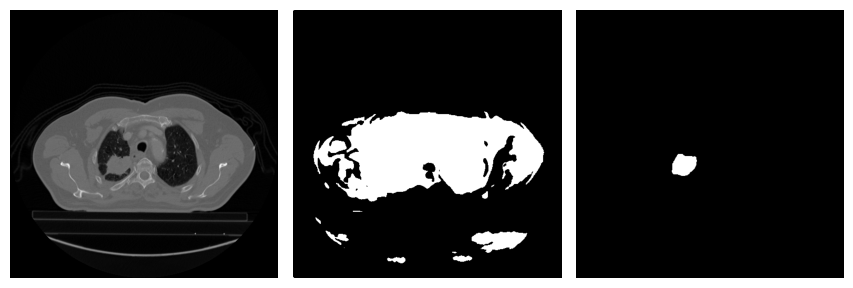

In [63]:
import matplotlib.pyplot as plt
import cv2
import pydicom
import os
import numpy as np

example_indexes = np.arange(len(sgmd)) 

# Mapping entre index et fichier DICOM
patients = sorted(os.listdir("./test/dcm/"))
dicom_paths = []

for patient in patients:
    images_dir = f"./test/dcm/{patient}/0/"
    dicom_files = sorted(os.listdir(images_dir))
    for dicom_file in dicom_files:
        dicom_paths.append((os.path.join(images_dir, dicom_file), patient))

for i in range(10):
    rand_idx = np.random.choice(example_indexes)

    dicom_path, patient = dicom_paths[rand_idx]
    img_dcm = pydicom.dcmread(dicom_path)
    img = img_dcm.pixel_array

    pred_mask = sgmd[rand_idx] > lamhat

    # Redimensionner la prédiction à la taille de l’image
    pred_mask_resized = cv2.resize(pred_mask.astype(np.uint8), img.shape[::-1], interpolation=cv2.INTER_NEAREST)

    # Masque gt
    gt_mask = gt_masks[rand_idx]
    if gt_mask.shape != img.shape:
        gt_mask = cv2.resize(gt_mask.astype(np.uint8), img.shape[::-1], interpolation=cv2.INTER_NEAREST)

    # Affichage
    fig, axs = plt.subplots(1, 3, figsize=(8.64, 4.76))

    axs[0].imshow(img, cmap='gray')
    axs[0].axis('off')

    axs[1].imshow(pred_mask_resized, cmap='gray')
    axs[1].axis('off')

    axs[2].imshow(gt_mask, cmap='gray')
    axs[2].axis('off')

    if i == 0:
        axs[0].set_title('input')
        axs[1].set_title('predicted mask')
        axs[2].set_title('ground truth mask')

    plt.tight_layout()
    plt.show()
